# ELUC Administrative Segmentation

In this notebook you will find a geographical segmentation of administrative regions.

## Contents

- 1. Introduction
  - 1.1. Data source
- 2. Download GADM data (version 4.1)
- 3. Data processing
  - 3.1. Load GADM
  - 3.2. Data visualization
  - 3.3. Map the shapefile into data objects
  - 3.4. Segemntation
- 4. Save data on disk

## 1. Introduction

From an administration point of view, a country can be seen as a collection of different regions or units. Each region or unit is a subnational entity which is given some degrees of autonomy and decision capacity. 

While some decisions are taken at international or national, there are some decisions that are taken at regional level. There are regional differences in weather patterns, agricultural production, and anticipated regional variation in climate change impacts. 

To map each decision unit, we will use GADM, a geocode standard, or system, that is open source and internationally recognized.

![GADM](https://www.arcgis.com/sharing/rest/content/items/5994df71197346a5bb9d0916d86df7f6/info/thumbnail/thumbnail1664450856103.png?w=800)

The main focus of *Project Resilience* is to perform analisis at a county administrative level. This notebook will segment geographical data into administrative regions. 

### 1.1. Data source

The Global Administrative Areas (GADM) vector dataset series, developed by a group of zoologists and agricultural scientists in California, is the world coverage for administrative units at different administrative levels.

Delimiting a total of 400,276 boundaries, GADM open data project delivers distinct datasets representing administrative boundaries for each country and its respective political subdivisions. The dataset series is comprised of the six administrative levels global datasets for: 

- National (level 0), 
- State/province/equivalent (level 1), 
- **County/district/equivalent (level 2)**, 
- Commune/municipality/equivalent (level 3), and smaller Levels 4 and 5. 

Attributes for Level 0 comprise country name in English and ISO 3166-1 alpha3 coding. Administrative units associated with attribute information include official names in Latin and non-Latin scripts, variant names, administrative type in local and English.

Administrative Level 4 is available for 20 countries and Level 5 for France and Rwanda.

The GADM project created the spatial data for many countries from spatial databases provided by national governments, NGO, and/or from maps and lists of names available on the Internet.


| GADM Database | |
|:--|---|
| URL: | https://gadm.org/ |
| Date: | 16 July 2022 |
| Version: | 4.1 |
| Repository: | *University of California, Davis* |
| License: | Freely available for academic and other non-commercial use |


 

## 2. Download GADM data (version 4.1)

We will download all level 2 administrative regions, from 171 countries, that are available at UC Davis repository and temporarly store them for integration with ELUC dataset.

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import regionmask
import os
import geopandas as gpd
from affine import Affine
from rasterio import features
import requests
import zipfile 
import io

In [2]:
# GADM Global Administrative Areas
repo_url = "https://geodata.ucdavis.edu/gadm/gadm4.1/"
gadm_level = "2"
file_extension = "json" # GeoJSON
url_gadm_catalogue = "https://geodata.ucdavis.edu/gadm/gadm4.1.txt"

# Read GADM catalogue
r = requests.get(url_gadm_catalogue)
catalogue = r.text.split("\n")
gadm_level = "2" # administrative level

catalogue_level_2 = [file[:-7] + ".json.zip" for file in catalogue if gadm_level in file]

# Set geojson storage path to data/raw/gadm/json/
storage_location_gadm_json = "./raw/gadm/json/"

In [ ]:
# Download extract and store GADM level 2 geojson files
for file in catalogue_level_2:    
    url_full = repo_url+file_extension+"/"+file
    local_storage = storage_location_gadm_json+file[:-4]
    if not os.path.isfile(local_storage):
        response = requests.get(url_full)
        if response.status_code == 200:
            print(f'GADM level 2 for {local_storage}: Downloading...')
            r = requests.get(url_full, stream=True)
            z = zipfile.ZipFile(io.BytesIO(r.content))
            z.extractall(storage_location_gadm_json)
        else:
            print(f'GADM level 2 for {local_storage}: Not available')

In [ ]:
# Create a local GADM catalogue 
geojson_catalogue = [file[:-4] for file in catalogue_level_2]
countries_catalogue = [filename.split("_")[1] for filename in geojson_catalogue]
gadm_country_catalogue = pd.DataFrame.from_dict(
    dict(zip(countries_catalogue, geojson_catalogue)),
    orient="index", columns=["geojson"])
gadm_country_catalogue["local_path"] = gadm_country_catalogue["geojson"].apply(lambda x: storage_location_gadm_json + x)

In [ ]:
gadm_country_catalogue.reset_index().to_csv(storage_location_gadm_json + "../gadm_country_catalogue.csv", index=False)

## 3. Data processing


###  3.1. Load GADM 


In [ ]:
# Example: Canada
country = "CAN"
gadm = gpd.read_file(gadm_country_catalogue.loc[country].values[1])
gadm.head(2)

,GID_2,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry
0,CAN.1.11_1,CAN,Canada,CAN.1_1,Alberta,NA,DivisionNo.1,NA,NA,CensusDivision,CensusDivision,01,CA.AB.ON,"MULTIPOLYGON (((-110.73940 49.00000, -111.3413..."
1,CAN.1.1_1,CAN,Canada,CAN.1_1,Alberta,NA,DivisionNo.10,NA,NA,CensusDivision,CensusDivision,10,CA.AB.TE,"MULTIPOLYGON (((-112.31920 53.01780, -112.3263..."


Each row represents a city, or other administrative division like *"Alberta, DivisionNo.1"*.
For each region, we can find the name, county and official name, along with other types of meta-data. The last column, geometry, contains a multipolygon, a geographical representation of the administrative region.

### 3.2. Data visualization


To visualize a GADM file we will use *Canada* as example to see the level 2 regions delimited by white borders.

Text(289.305836544005, 0.5, 'Latitude [Degrees North]')

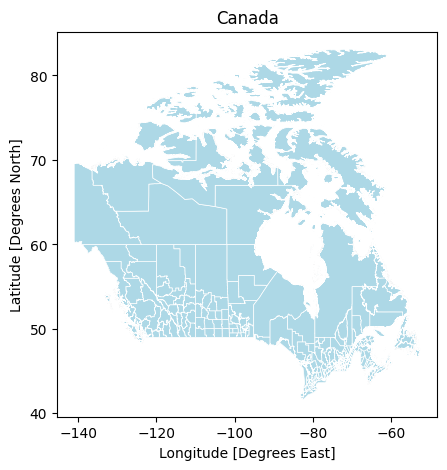

In [ ]:
# Example: Canada
CAN = gadm[gadm.GID_0 == 'CAN']
ax = ax = CAN.plot(figsize=(10,5), linewidth=0.5, edgecolor='white', color='lightblue')
ax.set_title("Canada")
ax.set_xlabel('Longitude [Degrees East]')
ax.set_ylabel('Latitude [Degrees North]')

### 3.3. Create administrative regions from GADM

We want to select *level 2* identifiers like `NAME_2` and `GID_2` for each administrative region.

In [ ]:
CAN[["NAME_1", "GID_1", "NAME_2", "GID_2", "geometry"]].head(2)

,NAME_1,GID_1,NAME_2,GID_2,geometry
0,Alberta,CAN.1_1,DivisionNo.1,CAN.1.11_1,"MULTIPOLYGON (((-110.73940 49.00000, -111.3413..."
1,Alberta,CAN.1_1,DivisionNo.10,CAN.1.1_1,"MULTIPOLYGON (((-112.31920 53.01780, -112.3263..."


**Level 1** 
Administrative regions

In [ ]:
pd.DataFrame(CAN.NAME_1.unique()).head(3)

,0
0,Alberta
1,BritishColumbia
2,Manitoba


**Level 2** administrative regions

In [ ]:
pd.DataFrame(CAN.NAME_2.unique()).head(3)

,0
0,DivisionNo.1
1,DivisionNo.10
2,DivisionNo.11


### 3.4. Segmentation


Using level 2 region name `NAME_2` is not sufficient to clearly identify a region. We will concatenate `NAME_1` and `NAME_2` for further context. 

Example: *"Alberta, DivisionNo.1"*, *"Alberta, DivisionNo.10"*, ... 

**Collect GADM regions from all countries**

For each country, we will load the GADM file, containing the level 2 administrative regions, resolve the geometry of each region into a mask that will be applied to the ELUC dataset.

To do it, we have previously stored all the necessary files in `/data/gcb/raw/gadm/json/`. A catalogue is also available to iterate throught them. 

For more information on how to create regions, please check [regionmask documentation](https://regionmask.readthedocs.io/en/stable/notebooks/create_own_regions.html#use-shapely-polygon).

In [ ]:
gadm_region_names = []
gadm_region_codes = []
gadm_region_geoms = []

for country in gadm_country_catalogue.index:
    gadm = gpd.read_file(gadm_country_catalogue.loc[country].values[1]) # read gadm country file
    gadm = gadm.dissolve("NAME_2").reset_index() # groupby at level 2, including geometry
    gadm_region_names.extend(list(map(lambda x, y: x + ", " + y,
                                      list(gadm.reset_index().NAME_1.values), 
                                      list(gadm.reset_index().NAME_2.values)))) # region name
    gadm_region_codes.extend(list(gadm.reset_index().GID_2.values)) # region code
    gadm_region_geoms.extend(list(gadm.reset_index().geometry.values)) # region geometry

In [ ]:
gadm_level2_mask = regionmask.Regions(outlines = gadm_region_geoms, 
                                      names = gadm_region_names, 
                                      abbrevs = gadm_region_codes, 
                                      name = "gadm_level2_regions")

Load ELUC dataset and apply region masks:

- Countries 110 mask
- Global Administrative Regions (GADM) mask

In [ ]:
# Load ELUC dataset
ds = xr.open_zarr("merged_aggregated_dataset.zarr", consolidated=True)
ds = ds.stack(latlon=('lat', 'lon'))

In [ ]:
%%time
# Apply countries and region masks
country_mask = regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask(ds)

CPU times: user 5.7 s, sys: 3 µs, total: 5.7 s
Wall time: 5.7 s


In [ ]:
%%time
# Apply countries and region masks
gadm_mask = gadm_level2_mask.mask(ds)

CPU times: user 23min 7s, sys: 87.1 ms, total: 23min 7s
Wall time: 23min 7s


In [ ]:
%%time
ds = ds.assign_coords({"country":country_mask, 
                       "gadm_region":gadm_mask})

CPU times: user 398 ms, sys: 60 ms, total: 458 ms
Wall time: 426 ms


## 4. Save data 

[Zarr](https://zarr.readthedocs.io/en/stable/) is a Python package and data format providing an implementation of chunked, compressed, N-dimensional arrays. Zarr has the ability to store arrays in a range of ways, including in memory, in files, and in cloud-based object storage such as Amazon S3 and Google Cloud Storage. 

Xarray’s Zarr backend allows xarray to leverage these capabilities.

In [ ]:
ds.unstack().to_netcdf("./raw/netcdf/eluc_country_gadm.nc")

/tmp/ipykernel_346500/2301665615.py:1: SerializationWarning: saving variable mask with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds.unstack().to_netcdf("eluc_country_gadm.nc")


In [ ]:
ds = ds.where(ds.country.notnull() & ds.gadm_region.notnull(), drop=True)
ds

<xarray.Dataset>
Dimensions:         (time: 173, latlon: 229121)
Coordinates:
    mask            (latlon) int8 dask.array<chunksize=(49,), meta=np.ndarray>
  * time            (time) int32 1850 1851 1852 1853 ... 2019 2020 2021 2022
  * latlon          (latlon) object MultiIndex
  * lat             (latlon) float32 82.88 82.88 82.88 ... -55.38 -55.38 -55.38
  * lon             (latlon) float32 -79.38 -79.12 -78.88 ... -68.62 -68.38
    country         (latlon) float64 3.0 3.0 3.0 3.0 3.0 ... 10.0 10.0 10.0 10.0
    gadm_region     (latlon) float64 8.407e+03 8.407e+03 ... 8.801e+03 8.801e+03
Data variables: (12/28)
    ELUC            (time, latlon) float32 dask.array<chunksize=(173, 49), meta=np.ndarray>
    ELUC_diff       (time, latlon) float32 dask.array<chunksize=(173, 49), meta=np.ndarray>
    c3ann           (time, latlon) float32 dask.array<chunksize=(173, 49), meta=np.ndarray>
    c3ann_diff      (time, latlon) float32 dask.array<chunksize=(173, 49), meta=np.ndarray>
    c3nfx           (time, latlon) float32 dask.array<chunksize=(173, 49), meta=np.ndarray>
    c3nfx_diff      (time, latlon) float32 dask.array<chunksize=(173, 49), meta=np.ndarray>
    ...              ...
    secdf           (time, latlon) float32 dask.array<chunksize=(173, 49), meta=np.ndarray>
    secdf_diff      (time, latlon) float32 dask.array<chunksize=(173, 49), meta=np.ndarray>
    secdn           (time, latlon) float32 dask.array<chunksize=(173, 49), meta=np.ndarray>
    secdn_diff      (time, latlon) float32 dask.array<chunksize=(173, 49), meta=np.ndarray>
    urban           (time, latlon) float32 dask.array<chunksize=(173, 49), meta=np.ndarray>
    urban_diff      (time, latlon) float32 dask.array<chunksize=(173, 49), meta=np.ndarray>

In [ ]:
# Load eluc_country_gadm dataset
ds = xr.open_dataset("./raw/netcdf/eluc_country_gadm.nc")
ds = ds.stack(latlon=('lat', 'lon'))

: 

: 